# Neural networks

## Contents in this notebook:
1. [Notebook setup](#setup)
2. [Normalization layer](#norm)
3. [Hyperparameter tuning](#hp)
3. [Train model](#train)

## 1. Notebook setup <a name="setup"></a>

In [1]:
# Install required packages.
# !pip install requirements.txt

# Change directory to main project folder.
import os
print(f'This folder: {os.getcwd()}')
os.chdir("..")
print(f'Project folder: {os.getcwd()}\n')

# Import packages.
import routing
import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

This folder: C:\Users\muell\thesis_main\thesis_code\notebooks
Project folder: C:\Users\muell\thesis_main\thesis_code

2.7.1


In [2]:
# Load training data

X_train = pd.read_pickle('data/generated_final_pickle/df_features_train.pickle')
y_train = X_train.pop('distance')
print(X_train.shape, y_train.shape)

(80000, 43) (80000,)


In [3]:
def plot_loss(history, ylim=None):
    """Plots the training and validation loss."""
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    if ylim:
        plt.ylim([0, ylim])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

## 2. Normalization layer <a name="norm"></a>

In [6]:
# check if normalization is necessary (Yes vary different values, so slow convergence otherwise)
#X_train.describe().transpose()[['mean', 'std']]

In [7]:
# create normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

[[5.9480198e+01 5.4176587e+02 2.1642188e+03 1.6218473e+00 4.3608931e-01
  4.4843009e-01 1.7860065e-01 3.2225946e-01 1.2018441e+00 7.6551199e-02
  6.5177357e-01 2.5920025e-01 1.4885765e-01 6.5643066e-01 1.1377072e+00
  8.2608378e-01 6.0028362e-01 3.3129346e-01 1.2041565e-02 5.7752073e-01
  1.4954176e+00 4.1272888e-01 4.3921933e+00 8.7102786e-02 4.1021459e-02
  3.6058377e-02 8.0570020e-02 1.7390339e-01 4.6991272e+00 4.3645412e-02
  1.2746317e-02 2.3084512e-02 4.3331474e-02 6.5763660e-02 7.4963242e-01
  4.7634050e-01 2.6871505e-01 1.9754811e-01 4.1149381e-01 4.8561433e-01
  2.0350088e-01 8.9938439e-02 8.7512821e-01]]


In [8]:
# test normalization layer
first = np.array(X_train.iloc[:1,:])
with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[  78.    830.72 3272.02    1.84    0.61    0.4     0.19    0.29    1.11
     0.05    0.71    0.26    0.07    0.77    1.31    0.88    0.54    0.3
     0.      0.51    1.46    0.78    1.28    0.02    0.01    0.      0.02
     0.03    3.57    0.06    0.      0.06    0.06    0.06    0.86    0.57
     0.18    0.42    0.51    0.45    0.24    0.04    0.87]]

Normalized: [[ 0.8   1.39  1.36  0.29  0.5  -0.53  0.19 -0.57 -0.44 -0.89  0.23  0.
  -0.44  0.43  0.47  0.43 -0.61 -0.3  -0.94 -0.6  -0.16  1.65 -0.58 -0.64
  -0.51 -0.47 -0.57 -0.64 -0.48  0.9  -1.01  1.43  0.89 -0.04  0.59  0.52
  -0.85  1.25  0.36 -0.97  0.76 -0.94 -0.16]]


## 3. Hyperparameter tuning <a name="hp"></a>

### First cycle

In [17]:
def build_model(hp):
    model = tf.keras.Sequential()
    
    # input layer
    model.add(normalizer)
    
    # hidden layers
    num_layers = hp.Int('num_layers', 1, 3)
    if num_layers >= 1:
        hidden_1 = hp.Int('hidden_1', 8, 64, step=8)
        model.add(tf.keras.layers.Dense(units=hidden_1, activation='relu'))
    if num_layers >= 2:
        hidden_2 = hp.Int('hidden_2', 8, hidden_1, step=8)
        model.add(tf.keras.layers.Dense(units=hidden_2, activation='relu'))
    if num_layers >= 3:
        hidden_3 = hp.Int('hidden_3', 8, hidden_2, step=8)
        model.add(tf.keras.layers.Dense(units=hidden_3, activation='relu'))
        
    # dropout layer
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    model.add(tf.keras.layers.Dropout(rate=dropout))
    
    # output layer
    model.add(tf.keras.layers.Dense(1))
    
    # compile
    learning_rate = hp.Float(
                'learning_rate',
                min_value=0.0005,
                max_value=0.5,
                sampling='LOG',
                default=0.005)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='mean_squared_error', 
        metrics=['mean_squared_error']
    )
    #hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'models/mlp_tuning',
    project_name="cycle1",   
)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project models/mlp_tuning\cycle1\oracle.json
INFO:tensorflow:Reloading Tuner from models/mlp_tuning\cycle1\tuner0.json
Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
hidden_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.005, 'conditions': [], 'min_value': 0.0005, 'max_value': 0.5, 'step': None, 'sampling': 'log'}
hidden_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
hidden_3 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 8, 'step': 8, 'sampling': None}


In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train.astype(float), y_train, epochs=150, validation_split=0.25, callbacks=[stop_early])

Trial 10 Complete [00h 01m 28s]
val_loss: 3201178.5

Best val_loss So Far: 759628.0
Total elapsed time: 00h 11m 33s
INFO:tensorflow:Oracle triggered exit


In [12]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 43)               87        
 n)                                                              
                                                                 
 dense (Dense)               (None, 24)                1056      
                                                                 
 dense_1 (Dense)             (None, 32)                800       
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                        

In [13]:
best_model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.018711245>

In [14]:
tuner.results_summary()

Results summary
Results in models/mlp_tuning\cycle1
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 3
hidden_1: 24
dropout: 0.1
learning_rate: 0.018711244929899274
hidden_2: 32
hidden_3: 8
Score: 759628.0
Trial summary
Hyperparameters:
num_layers: 3
hidden_1: 64
dropout: 0.05
learning_rate: 0.07230473728989745
hidden_2: 8
hidden_3: 8
Score: 865842.875
Trial summary
Hyperparameters:
num_layers: 2
hidden_1: 24
dropout: 0.25
learning_rate: 0.0010901803326811247
hidden_2: 32
hidden_3: 8
Score: 990288.875
Trial summary
Hyperparameters:
num_layers: 1
hidden_1: 24
dropout: 0.25
learning_rate: 0.017106562733463084
Score: 1241902.0
Trial summary
Hyperparameters:
num_layers: 3
hidden_1: 40
dropout: 0.15000000000000002
learning_rate: 0.0029589526922115545
hidden_2: 40
hidden_3: 8
Score: 1327503.625
Trial summary
Hyperparameters:
num_layers: 1
hidden_1: 48
dropout: 0.25
learning_rate: 0.2293929615124925
hidden_2: 48
hidden_3: 8
Score: 1

### Second cycle

In [ ]:
# search again with lower dropout and narrower learning rate, and higher minimum of nodes in fist layer

In [19]:
def build_model(hp):
    model = tf.keras.Sequential()
    
    # input layer
    model.add(normalizer)
    
    # hidden layers
    num_layers = hp.Int('num_layers', 1, 3)
    if num_layers >= 1:
        hidden_1 = hp.Int('hidden_1', 32, 64, step=8)
        model.add(tf.keras.layers.Dense(units=hidden_1, activation='relu'))
    if num_layers >= 2:
        hidden_2 = hp.Int('hidden_2', 8, hidden_1, step=8)
        model.add(tf.keras.layers.Dense(units=hidden_2, activation='relu'))
    if num_layers >= 3:
        hidden_3 = hp.Int('hidden_3', 8, hidden_2, step=8)
        model.add(tf.keras.layers.Dense(units=hidden_3, activation='relu'))
        
    # dropout layer
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.2, default=0.1, step=0.05)
    model.add(tf.keras.layers.Dropout(rate=dropout))
    
    # output layer
    model.add(tf.keras.layers.Dense(1))
    
    # compile
    learning_rate = hp.Float(
                'learning_rate',
                min_value=0.0006,
                max_value=0.2,
                sampling='LOG',
                default=0.005)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='mean_squared_error', 
        metrics=['mean_squared_error']
    )
    #hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'models/mlp_tuning',
    project_name="cycle2",   
)
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
hidden_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 8, 'sampling': None}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.005, 'conditions': [], 'min_value': 0.0006, 'max_value': 0.2, 'step': None, 'sampling': 'log'}


In [20]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train.astype(float), y_train, epochs=150, validation_split=0.25, callbacks=[stop_early])

Trial 10 Complete [00h 01m 18s]
val_loss: 722759.8125

Best val_loss So Far: 722759.8125
Total elapsed time: 00h 26m 29s
INFO:tensorflow:Oracle triggered exit


In [21]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 43)               87        
 n)                                                              
                                                                 
 dense (Dense)               (None, 56)                2464      
                                                                 
 dense_1 (Dense)             (None, 16)                912       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,480
Trainable params: 3,393
Non-trainable params: 87
_____________________________________________________

In [22]:
best_model.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.010075742>

In [23]:
tuner.results_summary()

Results summary
Results in models/mlp_tuning\cycle2
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
hidden_1: 56
dropout: 0.1
learning_rate: 0.010075742588331075
hidden_2: 16
hidden_3: 8
Score: 722759.8125
Trial summary
Hyperparameters:
num_layers: 2
hidden_1: 56
dropout: 0.05
learning_rate: 0.002621672943133397
hidden_2: 16
hidden_3: 8
Score: 727945.125
Trial summary
Hyperparameters:
num_layers: 2
hidden_1: 32
dropout: 0.15000000000000002
learning_rate: 0.03650917155327627
hidden_2: 8
Score: 757519.3125
Trial summary
Hyperparameters:
num_layers: 2
hidden_1: 40
dropout: 0.1
learning_rate: 0.023460743772296136
hidden_2: 24
hidden_3: 8
Score: 772730.4375
Trial summary
Hyperparameters:
num_layers: 1
hidden_1: 64
dropout: 0.15000000000000002
learning_rate: 0.0050637465425208365
hidden_2: 8
hidden_3: 8
Score: 828974.875
Trial summary
Hyperparameters:
num_layers: 2
hidden_1: 48
dropout: 0.1
learning_rate: 0.002196849727547194
hi

### Third cycle

In [ ]:
# further decrease dropout and minimum two layers and narrower learning rate

In [28]:
def build_model(hp):
    model = tf.keras.Sequential()
    
    # input layer
    model.add(normalizer)
    
    # hidden layers
    num_layers = hp.Int('num_layers', 2, 3)
    if num_layers >= 1:
        hidden_1 = hp.Int('hidden_1', 32, 64, step=8)
        model.add(tf.keras.layers.Dense(units=hidden_1, activation='relu'))
    if num_layers >= 2:
        hidden_2 = hp.Int('hidden_2', 8, hidden_1, step=8)
        model.add(tf.keras.layers.Dense(units=hidden_2, activation='relu'))
    if num_layers >= 3:
        hidden_3 = hp.Int('hidden_3', 8, hidden_2, step=8)
        model.add(tf.keras.layers.Dense(units=hidden_3, activation='relu'))
        
    # dropout layer
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.1, default=0.1, step=0.05)
    model.add(tf.keras.layers.Dropout(rate=dropout))
    
    # output layer
    model.add(tf.keras.layers.Dense(1))
    
    # compile
    learning_rate = hp.Float(
                'learning_rate',
                min_value=0.001,
                max_value=0.02,
                step=0.001,
                default=0.005)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='mean_squared_error', 
        metrics=['mean_squared_error']
    )
    #hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'models/mlp_tuning',
    project_name="cycle3",   
)
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': None}
hidden_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 8, 'sampling': None}
hidden_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 8, 'sampling': None}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.005, 'conditions': [], 'min_value': 0.001, 'max_value': 0.02, 'step': 0.001, 'sampling': None}


In [29]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
tuner.search(X_train.astype(float), y_train, epochs=200, validation_split=0.25, callbacks=[stop_early])

Trial 10 Complete [00h 02m 52s]
val_loss: 554155.9375

Best val_loss So Far: 500756.1875
Total elapsed time: 00h 22m 20s
INFO:tensorflow:Oracle triggered exit


In [30]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 43)               87        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                2816      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,016
Trainable params: 4,929
Non-trainable params: 87
_____________________________________________________

In [31]:
best_model.optimizer.lr

ValueError: Tensor conversion requested dtype float32 for Tensor with dtype float64: <tf.Tensor: shape=(), dtype=float64, numpy=0.014000000000000002>

In [32]:
tuner.results_summary()

Results summary
Results in models/mlp_tuning\cycle3
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
hidden_1: 64
hidden_2: 32
dropout: 0.05
learning_rate: 0.014000000000000002
hidden_3: 8
Score: 500756.1875
Trial summary
Hyperparameters:
num_layers: 2
hidden_1: 56
hidden_2: 24
dropout: 0.05
learning_rate: 0.007
hidden_3: 8
Score: 516823.71875
Trial summary
Hyperparameters:
num_layers: 2
hidden_1: 64
hidden_2: 16
dropout: 0.05
learning_rate: 0.005
hidden_3: 8
Score: 530332.375
Trial summary
Hyperparameters:
num_layers: 3
hidden_1: 56
hidden_2: 16
dropout: 0.1
learning_rate: 0.005
hidden_3: 8
Score: 554155.9375
Trial summary
Hyperparameters:
num_layers: 3
hidden_1: 64
hidden_2: 16
dropout: 0.1
learning_rate: 0.004
hidden_3: 8
Score: 568335.125
Trial summary
Hyperparameters:
num_layers: 3
hidden_1: 48
hidden_2: 24
dropout: 0.1
learning_rate: 0.02
hidden_3: 8
Score: 622627.875
Trial summary
Hyperparameters:
num_layers: 2
hidde

### Fourth cycle

In [33]:
# narrow down params

In [34]:
def build_model(hp):
    model = tf.keras.Sequential()
    
    # input layer
    model.add(normalizer)
    
    # hidden layers
    num_layers = 2

    hidden_1 = hp.Int('hidden_1', 48, 64, step=8)
    model.add(tf.keras.layers.Dense(units=hidden_1, activation='relu'))

    hidden_2 = hp.Int('hidden_2', 16, hidden_1, step=8)
    model.add(tf.keras.layers.Dense(units=hidden_2, activation='relu'))

        
    # dropout layer
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.1, default=0.1, step=0.05)
    model.add(tf.keras.layers.Dropout(rate=dropout))
    
    # output layer
    model.add(tf.keras.layers.Dense(1))
    
    # compile
    learning_rate = hp.Float(
                'learning_rate',
                min_value=0.002,
                max_value=0.018,
                step=0.001,
                default=0.005)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='mean_squared_error', 
        metrics=['mean_squared_error']
    )
    #hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 10,
    executions_per_trial = 1,
    directory = 'models/mlp_tuning',
    project_name="cycle4",   
)
tuner.search_space_summary()

Search space summary
Default search space size: 4
hidden_1 (Int)
{'default': None, 'conditions': [], 'min_value': 48, 'max_value': 64, 'step': 8, 'sampling': None}
hidden_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 48, 'step': 8, 'sampling': None}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.005, 'conditions': [], 'min_value': 0.002, 'max_value': 0.018, 'step': 0.001, 'sampling': None}


In [35]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)
tuner.search(X_train.astype(float), y_train, epochs=220, validation_split=0.2, callbacks=[stop_early])

Trial 10 Complete [00h 02m 43s]
val_loss: 475510.09375

Best val_loss So Far: 425945.09375
Total elapsed time: 00h 28m 47s
INFO:tensorflow:Oracle triggered exit


In [36]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 43)               87        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                2816      
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 49        
                                                                 
Total params: 6,072
Trainable params: 5,985
Non-trainable params: 87
_____________________________________________________

In [38]:
tuner.results_summary()

Results summary
Results in models/mlp_tuning\cycle4
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
hidden_1: 64
hidden_2: 48
dropout: 0.0
learning_rate: 0.016
Score: 425945.09375
Trial summary
Hyperparameters:
hidden_1: 64
hidden_2: 40
dropout: 0.05
learning_rate: 0.016
Score: 475510.09375
Trial summary
Hyperparameters:
hidden_1: 56
hidden_2: 40
dropout: 0.05
learning_rate: 0.017
Score: 476509.5
Trial summary
Hyperparameters:
hidden_1: 56
hidden_2: 32
dropout: 0.1
learning_rate: 0.004
Score: 520951.4375
Trial summary
Hyperparameters:
hidden_1: 56
hidden_2: 24
dropout: 0.05
learning_rate: 0.006
Score: 525912.25
Trial summary
Hyperparameters:
hidden_1: 56
hidden_2: 16
dropout: 0.05
learning_rate: 0.005
Score: 543973.625
Trial summary
Hyperparameters:
hidden_1: 48
hidden_2: 16
dropout: 0.1
learning_rate: 0.013
Score: 544808.5625
Trial summary
Hyperparameters:
hidden_1: 64
hidden_2: 32
dropout: 0.1
learning_rate: 0.016
Score: 547838.875
Tr

## Final Model

In [9]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(48, activation='relu'),
        layers.Dense(1)
  ])

    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.016))
    return model

In [10]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 43)               87        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                2816      
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
 dense_2 (Dense)             (None, 1)                 49        
                                                                 
Total params: 6,072
Trainable params: 5,985
Non-trainable params: 87
_________________________________________________________________


In [11]:
EPOCHS = 500

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/mlp_training/checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [12]:
%%time
# Model training
history = dnn_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2, 
    callbacks=[model_checkpoint_callback, stop_early])

Epoch 1/500
2000/2000 [==============================] - 5s 2ms/step - loss: 4976178.5000 - val_loss: 2147915.0000
Epoch 2/500
2000/2000 [==============================] - 4s 2ms/step - loss: 1344964.2500 - val_loss: 1490915.6250
Epoch 3/500
2000/2000 [==============================] - 4s 2ms/step - loss: 1070301.5000 - val_loss: 913152.8125
Epoch 4/500
2000/2000 [==============================] - 4s 2ms/step - loss: 937471.6875 - val_loss: 1833545.5000
Epoch 5/500
2000/2000 [==============================] - 4s 2ms/step - loss: 829707.0625 - val_loss: 842388.5625
Epoch 6/500
2000/2000 [==============================] - 4s 2ms/step - loss: 789865.1250 - val_loss: 934691.5000
Epoch 7/500
2000/2000 [==============================] - 4s 2ms/step - loss: 709661.3125 - val_loss: 804213.0625
Epoch 8/500
2000/2000 [==============================] - 4s 2ms/step - loss: 679768.5625 - val_loss: 1007557.6250
Epoch 9/500
2000/2000 [==============================] - 4s 2ms/step - loss: 634447.3125 

In [20]:
# The model weights (that are considered the best) are loaded into the model.
dnn_model.load_weights('models/mlp_training/checkpoint')

In [23]:
# save the model
dnn_model.save('models/dnn_model_final')

INFO:tensorflow:Assets written to: models/dnn_model_final\assets


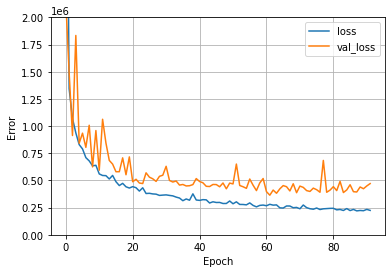

In [15]:
# Show performance in last epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

# Plot loss
plot_loss(history, ylim=2000000)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


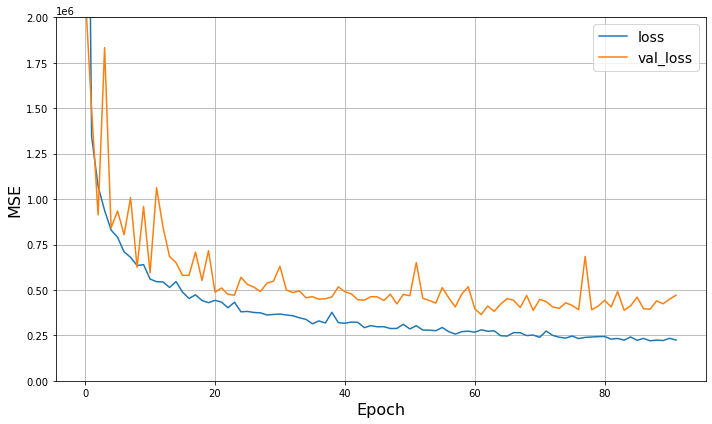

In [34]:
# plot in high quality

fig, ax = plt.subplots(1, figsize=(10,6))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 2000000])
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
fig.tight_layout()
#plt.savefig('mlp_training.eps', format='eps', pad_inches=0.4)#bbox_inches='tight')
plt.show()